In [ ]:
!nvidia-smi

Thu Jul  8 01:41:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install albumentations==0.4.6

In [ ]:
import torch
import torchvision
import numpy as np
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from functools import partial
%matplotlib inline

cv = partial(nn.Conv2d, bias=False)
bn = nn.BatchNorm2d
relu = nn.ReLU

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensor

In [ ]:
transform = transforms.Compose([transforms.ToTensor()]) # simple ToTensor for now

train_set = torchvision.datasets.CIFAR10(root='./cifar10', download=True, train=True, transform=transform)


Files already downloaded and verified


In [ ]:
train_set.data.shape # train data shape

(50000, 32, 32, 3)

In [ ]:
# calculate mean and standard deviation

m = np.mean(train_set.data, axis=(0,1,2))
print(m/255)

s = np.std(train_set.data, axis=(0, 1, 2))
print(s/255)

[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


In [ ]:
mean = m/255
sdev = s/255

In [ ]:
SEED = 101
BATCH = 256

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

if cuda:
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")

# dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=BATCH, num_workers=2, pin_memory=True)\
    if cuda else dict(shuffle=True, batch_size=32)


CUDA Available? True


In [ ]:
# # transforms
# train_transforms = transforms.Compose([transforms.ToTensor(),
#                                        transforms.Normalize(mean=mean, std=sdev)
#                                        ])

# test_transforms = transforms.Compose([transforms.ToTensor(),
#                                       transforms.Normalize(mean=mean, std=sdev)])

# # data sets with transforms
# train_set = torchvision.datasets.CIFAR10(root='./cifar-10', download=True, train=True, transform=train_transforms)

# test_set = torchvision.datasets.CIFAR10('./cifar-10', train=False, download=True, transform=test_transforms)


# # data loaders on data sets
# train_loader = torch.utils.data.DataLoader(dataset=train_set, **dataloader_args)

# test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

# from __future__ import print_function
# channel_means = (0.49139968, 0.48215841, 0.44653091)
# channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
# def unnormalize(img):
#   img = img.numpy().astype(dtype=np.float32)
  
#   for i in range(img.shape[0]):
#     img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
#   return np.transpose(img, (1,2,0))
#   #return np.transpose(img, (1, 2, 0))

# %matplotlib inline
# import matplotlib.pyplot as plt
# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# print(images.shape)
# print(labels.shape)

# num_classes = 10
# # display 10 images from each category. 
# class_names = ['airplane','automobile','bird','cat','deer',
#                'dog','frog','horse','ship','truck']
# r, c = 10, 11
# n = 5
# fig = plt.figure(figsize=(10,10))
# fig.subplots_adjust(hspace=0.04, wspace=0.04)
# for i in range(num_classes):
#     idx = np.random.choice(np.where(labels[:]==i)[0], n)
#     ax = plt.subplot(r, c, i*c+1)
#     ax.text(-1.5, 0.5, class_names[i], fontsize=14)
#     plt.axis('off')
#     for j in range(1, n+1):
#       plt.subplot(r, c, i*c+j+1)
#       plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
#       plt.axis('off')
# plt.show()

In [ ]:
criterion = nn.CrossEntropyLoss()
def train_eval_model(model, train_loader, optimizer, device, epochs=1, test=False, test_loader=None, scheduler=None):
          
    model.train() # set the train mode
    
    # iterate over for `epochs` epochs and keep storing valuable info

    for epoch in range(epochs):
      correct = processed = train_loss = 0
    #   if scheduler:
    #     scheduler.step()

      print(f"\n epoch num ================================= {epoch+1}")
      
      pbar = tqdm(train_loader)
      
      for batch_idx, (data, target) in enumerate(pbar):
          data, target = data.to(device), target.to(device) # move data to `device`

          optimizer.zero_grad() # zero out the gradients to avoid accumulating them over loops

          output = model(data) # get the model's predictions

          loss = criterion(output, target) # calculate Negative Log Likelihood loss using ground truth labels and the model's predictions

          train_loss += loss.item() # add up the train loss

          loss.backward() # boom ! The magic function to perform backpropagation and calculate the gradients

          optimizer.step() # take 1 step for the optimizer and update the weights

          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

          correct += pred.eq(target.view_as(pred)).sum().item() #  compare and see how many predictions are coorect and then add up the count

          processed += len(data) # total processed data size

      acc = 100 * correct/processed

      train_losses.append(train_loss)

      train_accuracy.append(acc)

      if scheduler:
        print("\n\n\t\t\tLast LR -->", scheduler.get_last_lr())
        scheduler.step()

      pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
      
      
      train_loss /= len(train_loader.dataset)
      print('\n\t\t\tTrain metrics: accuracy: {}/{} ({:.4f}%)'.format(correct,
                                                              len(train_loader.dataset),
                                                              correct * 100 / len(train_loader.dataset)))

      if test: # moving to evaluation
          model.eval() # set the correct mode
          
          correct = test_loss = 0

          with torch.no_grad(): # to disable gradient calculation with no_grad context
              
              for data, target in test_loader:

                  data, target = data.to(device), target.to(device)
                  
                  output = model(data)
                  
                  test_loss += criterion(output, target).sum().item()  # sum up batch loss
                  
                  pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                  
                  correct += pred.eq(target.view_as(pred)).sum().item()

          test_loss /= len(test_loader.dataset)
          test_losses.append(test_loss)
          test_accuracy.append(100. * correct / len(test_loader.dataset))

          print('\n\tTest metrics: average loss: {:.4f}, accuracy: {}/{} ({:.5f}%)\n'.format(
              test_loss, correct, len(test_loader.dataset),
              100. * correct / len(test_loader.dataset)))

In [ ]:
def plot_graphs(*, train_losses, train_accuracy, test_losses, test_accuracy):
    fig, axs = plt.subplots(2,2,figsize=(20,10))
    axs[0, 0].plot(train_losses)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_accuracy)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_accuracy)
    axs[1, 1].set_title("Test Accuracy")

In [ ]:
class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="./data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

In [ ]:
# transforms

# here changed CoarseDropout's p to 0.25 from default 0.5, along with minor change in MedianBlur value and HSV' value
train_transforms = A.Compose([
                                A.HorizontalFlip(p=0.2),
                                A.ShiftScaleRotate(shift_limit=0.14,scale_limit=0.15,rotate_limit=30,p=0.24),
                                A.CoarseDropout(max_holes=1, p=0.3, max_height=16,
                                                max_width=16, min_holes=1, min_height=16,
                                                min_width=16, fill_value=mean),
                                # A.MedianBlur(blur_limit=3, p=0.1),
                                A.HueSaturationValue(p=0.1),
                            #   A.GaussianBlur(blur_limit=3, p=0.12),
                                # A.RandomBrightnessContrast(brightness_limit=0.09,contrast_limit=0.1, p=0.15),   
                                A.Normalize(mean=mean, std=sdev),
                                ToTensor()
                                       ])

test_transforms = A.Compose([
                            A.Normalize(mean=mean, std=sdev),
                            ToTensor()
                                    ])


In [ ]:

# data sets with transforms
train_set = Cifar10SearchDataset(train=True, download=True, transform=train_transforms)

test_set = Cifar10SearchDataset(train=False, download=True, transform=test_transforms)


# data loaders on data sets
train_loader = torch.utils.data.DataLoader(dataset=train_set, **dataloader_args)

test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 3, 32, 32])
torch.Size([256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

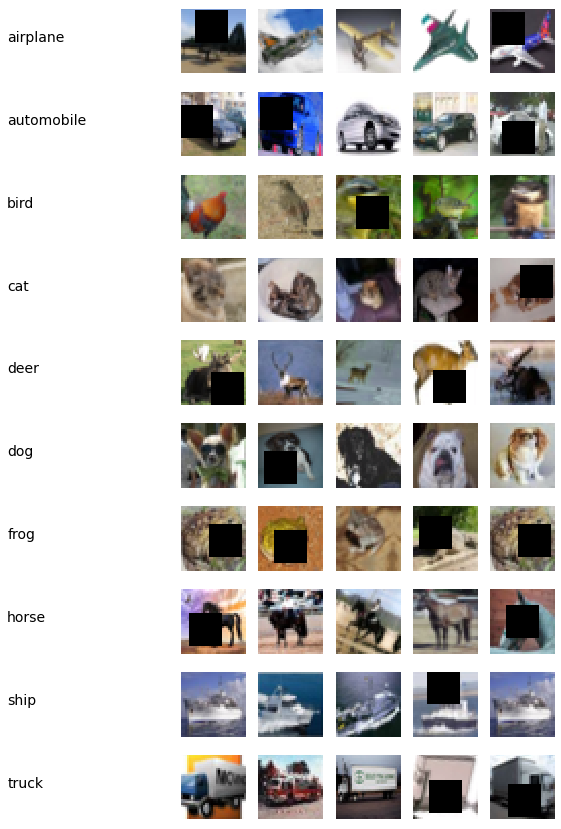

In [ ]:
from __future__ import print_function
# channel_means = (0.49196659, 0.48229005, 0.4461573)
# channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*sdev[i])+mean[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

# Code 10

In [ ]:
class Net10(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = nn.Sequential(
            cv(3, 16, 3, padding=1),
            relu(),
            bn(16),
            cv(16, 16, 3, padding=1, groups=1),
            relu(),
            bn(16),
            cv(16, 32, 3, padding=1, groups=8),
            relu(),
            bn(32),
            cv(32, 32, 1, padding=0, stride=1),
            relu(),
            bn(32)
        )

        self.block2 = nn.Sequential(
            cv(32, 64, 3, padding=1, dilation=1, groups=8),
            relu(),
            bn(64),
            cv(64, 24, 1),
            relu(),
            bn(24),
            cv(24, 64, 3, dilation=1, padding=0, groups=8),
            relu(),
            bn(64),
            cv(64, 32, 1),
            relu(),
            bn(32),
            cv(32, 64, 3, padding=1, dilation=2, groups=16),
            relu(),
            bn(64),
            cv(64, 32, 1),
            relu(),
            bn(32)
        )

        self.block3 = nn.Sequential(
            cv(32, 64, 3, dilation=1, padding=1, groups=32, stride=1),
            relu(),
            bn(64),
            cv(64, 128, 3, groups=32, dilation=1, padding=1),
            relu(),
            bn(128),
            cv(128, 64, 1),
            relu(),
            bn(64),
            cv(64, 96, 3, padding=1, groups=32),
            relu(),
            bn(96),
            cv(96, 64, 1),
            relu(),
            bn(64),
            cv(64, 64, 3, padding=2, dilation=2, stride=2),
            relu(),
            bn(64),
            cv(64, 64, 1),
            relu(),
            bn(64)
            )

        self.block4 = nn.Sequential(
            cv(64, 96, 3, padding=1, groups=16, stride=1, dilation=2),
            bn(96),
            relu(),
            cv(96, 64, 1),
            bn(64),
            relu(),
            cv(64, 64, 3, groups=64, padding=1, dilation=2), # depthwise (a)
            cv(64, 24, 1), # pointwise for preceding depthwise (b)
            bn(24),
            relu(),
            cv(24, 24, 3, dilation=2, groups=24, padding=0),
            relu(),
            bn(24),
            cv(24, 10, 1, stride=1),
            relu(),
            bn(10),
            nn.AdaptiveAvgPool2d(1)
        )
    
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


model = Net10().to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 16, 32, 32]           2,304
              ReLU-5           [-1, 16, 32, 32]               0
       BatchNorm2d-6           [-1, 16, 32, 32]              32
            Conv2d-7           [-1, 32, 32, 32]             576
              ReLU-8           [-1, 32, 32, 32]               0
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 32, 32, 32]           1,024
             ReLU-11           [-1, 32, 32, 32]               0
      BatchNorm2d-12           [-1, 32, 32, 32]              64
           Conv2d-13           [-1, 64, 32, 32]           2,304
             ReLU-14           [-1, 64,

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.0003, momentum=0.95, nesterov=False)

train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

train_eval_model(model, train_loader, optimizer, device, epochs=50, test=True, test_loader=test_loader,scheduler=None)

  0%|          | 0/196 [00:00<?, ?it/s]


 epoch num ================================= 1


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]


			Train metrics: accuracy: 7053/50000 (14.1060%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0085, accuracy: 2082/10000 (20.82000%)


 epoch num ================================= 2


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]


			Train metrics: accuracy: 11227/50000 (22.4540%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0075, accuracy: 2890/10000 (28.90000%)


 epoch num ================================= 3


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]


			Train metrics: accuracy: 14042/50000 (28.0840%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0071, accuracy: 3433/10000 (34.33000%)


 epoch num ================================= 4


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]


			Train metrics: accuracy: 16160/50000 (32.3200%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0067, accuracy: 3848/10000 (38.48000%)


 epoch num ================================= 5


100%|██████████| 196/196 [00:51<00:00,  3.81it/s]


			Train metrics: accuracy: 17614/50000 (35.2280%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0065, accuracy: 3988/10000 (39.88000%)


 epoch num ================================= 6


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]


			Train metrics: accuracy: 18820/50000 (37.6400%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0063, accuracy: 4129/10000 (41.29000%)


 epoch num ================================= 7


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]


			Train metrics: accuracy: 19736/50000 (39.4720%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0061, accuracy: 4304/10000 (43.04000%)


 epoch num ================================= 8


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]


			Train metrics: accuracy: 20196/50000 (40.3920%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0060, accuracy: 4552/10000 (45.52000%)


 epoch num ================================= 9


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]


			Train metrics: accuracy: 20673/50000 (41.3460%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0060, accuracy: 4552/10000 (45.52000%)


 epoch num ================================= 10


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]


			Train metrics: accuracy: 21173/50000 (42.3460%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0057, accuracy: 4801/10000 (48.01000%)


 epoch num ================================= 11


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]


			Train metrics: accuracy: 21995/50000 (43.9900%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0056, accuracy: 4907/10000 (49.07000%)


 epoch num ================================= 12


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]


			Train metrics: accuracy: 22473/50000 (44.9460%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0055, accuracy: 5059/10000 (50.59000%)


 epoch num ================================= 13


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]


			Train metrics: accuracy: 22897/50000 (45.7940%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0054, accuracy: 5200/10000 (52.00000%)


 epoch num ================================= 14


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]


			Train metrics: accuracy: 23311/50000 (46.6220%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0054, accuracy: 5183/10000 (51.83000%)


 epoch num ================================= 15


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]


			Train metrics: accuracy: 23987/50000 (47.9740%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0052, accuracy: 5384/10000 (53.84000%)


 epoch num ================================= 16


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]


			Train metrics: accuracy: 24254/50000 (48.5080%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0051, accuracy: 5415/10000 (54.15000%)


 epoch num ================================= 17


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]


			Train metrics: accuracy: 24645/50000 (49.2900%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0050, accuracy: 5456/10000 (54.56000%)


 epoch num ================================= 18


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]


			Train metrics: accuracy: 25113/50000 (50.2260%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0049, accuracy: 5516/10000 (55.16000%)


 epoch num ================================= 19


100%|██████████| 196/196 [00:51<00:00,  3.81it/s]


			Train metrics: accuracy: 25272/50000 (50.5440%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0047, accuracy: 5689/10000 (56.89000%)


 epoch num ================================= 20


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]


			Train metrics: accuracy: 25734/50000 (51.4680%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0047, accuracy: 5782/10000 (57.82000%)


 epoch num ================================= 21


100%|██████████| 196/196 [00:51<00:00,  3.81it/s]


			Train metrics: accuracy: 26079/50000 (52.1580%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0046, accuracy: 5839/10000 (58.39000%)


 epoch num ================================= 22


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]


			Train metrics: accuracy: 26249/50000 (52.4980%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0046, accuracy: 5913/10000 (59.13000%)


 epoch num ================================= 23


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]


			Train metrics: accuracy: 26459/50000 (52.9180%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0047, accuracy: 5844/10000 (58.44000%)


 epoch num ================================= 24


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]


			Train metrics: accuracy: 26645/50000 (53.2900%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0045, accuracy: 5931/10000 (59.31000%)


 epoch num ================================= 25


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]


			Train metrics: accuracy: 27085/50000 (54.1700%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0045, accuracy: 6017/10000 (60.17000%)


 epoch num ================================= 26


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]


			Train metrics: accuracy: 27375/50000 (54.7500%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0044, accuracy: 6034/10000 (60.34000%)


 epoch num ================================= 27


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]


			Train metrics: accuracy: 27714/50000 (55.4280%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0043, accuracy: 6133/10000 (61.33000%)


 epoch num ================================= 28


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]


			Train metrics: accuracy: 27860/50000 (55.7200%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0043, accuracy: 6078/10000 (60.78000%)


 epoch num ================================= 29


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]


			Train metrics: accuracy: 28152/50000 (56.3040%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0042, accuracy: 6187/10000 (61.87000%)


 epoch num ================================= 30


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]


			Train metrics: accuracy: 28438/50000 (56.8760%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0042, accuracy: 6208/10000 (62.08000%)


 epoch num ================================= 31


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]


			Train metrics: accuracy: 28604/50000 (57.2080%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0041, accuracy: 6236/10000 (62.36000%)


 epoch num ================================= 32


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]


			Train metrics: accuracy: 28869/50000 (57.7380%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0042, accuracy: 6262/10000 (62.62000%)


 epoch num ================================= 33


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]


			Train metrics: accuracy: 29293/50000 (58.5860%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0041, accuracy: 6296/10000 (62.96000%)


 epoch num ================================= 34


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]


			Train metrics: accuracy: 29181/50000 (58.3620%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0041, accuracy: 6390/10000 (63.90000%)


 epoch num ================================= 35


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]


			Train metrics: accuracy: 29545/50000 (59.0900%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0040, accuracy: 6453/10000 (64.53000%)


 epoch num ================================= 36


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]


			Train metrics: accuracy: 29630/50000 (59.2600%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0040, accuracy: 6442/10000 (64.42000%)


 epoch num ================================= 37


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]


			Train metrics: accuracy: 29918/50000 (59.8360%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0039, accuracy: 6528/10000 (65.28000%)


 epoch num ================================= 38


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]


			Train metrics: accuracy: 30222/50000 (60.4440%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0039, accuracy: 6498/10000 (64.98000%)


 epoch num ================================= 39


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]


			Train metrics: accuracy: 30374/50000 (60.7480%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0038, accuracy: 6592/10000 (65.92000%)


 epoch num ================================= 40


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]


			Train metrics: accuracy: 30597/50000 (61.1940%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0038, accuracy: 6679/10000 (66.79000%)


 epoch num ================================= 41


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]


			Train metrics: accuracy: 30850/50000 (61.7000%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0038, accuracy: 6690/10000 (66.90000%)


 epoch num ================================= 42


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]


			Train metrics: accuracy: 31016/50000 (62.0320%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0038, accuracy: 6592/10000 (65.92000%)


 epoch num ================================= 43


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]


			Train metrics: accuracy: 31158/50000 (62.3160%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0036, accuracy: 6768/10000 (67.68000%)


 epoch num ================================= 44


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]


			Train metrics: accuracy: 31217/50000 (62.4340%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0037, accuracy: 6726/10000 (67.26000%)


 epoch num ================================= 45


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]


			Train metrics: accuracy: 31272/50000 (62.5440%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0037, accuracy: 6683/10000 (66.83000%)


 epoch num ================================= 46


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]


			Train metrics: accuracy: 31578/50000 (63.1560%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0035, accuracy: 6804/10000 (68.04000%)


 epoch num ================================= 47


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]


			Train metrics: accuracy: 31740/50000 (63.4800%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0036, accuracy: 6844/10000 (68.44000%)


 epoch num ================================= 48


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]


			Train metrics: accuracy: 31544/50000 (63.0880%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0035, accuracy: 6909/10000 (69.09000%)


 epoch num ================================= 49


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]


			Train metrics: accuracy: 32173/50000 (64.3460%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0036, accuracy: 6795/10000 (67.95000%)


 epoch num ================================= 50


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]


			Train metrics: accuracy: 32189/50000 (64.3780%)



	Test metrics: average loss: 0.0036, accuracy: 6833/10000 (68.33000%)



In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)

train_eval_model(model, train_loader, optimizer, device, epochs=30, test=True, test_loader=test_loader,scheduler=None)

  0%|          | 0/196 [00:00<?, ?it/s]


 epoch num ================================= 1


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]


			Train metrics: accuracy: 23843/50000 (47.6860%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0054, accuracy: 5792/10000 (57.92000%)


 epoch num ================================= 2


100%|██████████| 196/196 [00:51<00:00,  3.81it/s]


			Train metrics: accuracy: 29799/50000 (59.5980%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0036, accuracy: 6779/10000 (67.79000%)


 epoch num ================================= 3


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]


			Train metrics: accuracy: 31651/50000 (63.3020%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0035, accuracy: 6914/10000 (69.14000%)


 epoch num ================================= 4


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]


			Train metrics: accuracy: 32261/50000 (64.5220%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0035, accuracy: 6868/10000 (68.68000%)


 epoch num ================================= 5


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]


			Train metrics: accuracy: 32624/50000 (65.2480%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0035, accuracy: 6910/10000 (69.10000%)


 epoch num ================================= 6


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]


			Train metrics: accuracy: 32794/50000 (65.5880%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0033, accuracy: 7061/10000 (70.61000%)


 epoch num ================================= 7


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]


			Train metrics: accuracy: 33052/50000 (66.1040%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0033, accuracy: 7014/10000 (70.14000%)


 epoch num ================================= 8


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]


			Train metrics: accuracy: 33315/50000 (66.6300%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0032, accuracy: 7141/10000 (71.41000%)


 epoch num ================================= 9


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]


			Train metrics: accuracy: 33464/50000 (66.9280%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0034, accuracy: 6980/10000 (69.80000%)


 epoch num ================================= 10


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]


			Train metrics: accuracy: 33687/50000 (67.3740%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0032, accuracy: 7194/10000 (71.94000%)


 epoch num ================================= 11


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]


			Train metrics: accuracy: 33857/50000 (67.7140%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0031, accuracy: 7238/10000 (72.38000%)


 epoch num ================================= 12


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]


			Train metrics: accuracy: 33893/50000 (67.7860%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0031, accuracy: 7276/10000 (72.76000%)


 epoch num ================================= 13


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]


			Train metrics: accuracy: 34141/50000 (68.2820%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0031, accuracy: 7212/10000 (72.12000%)


 epoch num ================================= 14


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]


			Train metrics: accuracy: 34308/50000 (68.6160%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0033, accuracy: 7153/10000 (71.53000%)


 epoch num ================================= 15


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]


			Train metrics: accuracy: 34304/50000 (68.6080%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0033, accuracy: 7236/10000 (72.36000%)


 epoch num ================================= 16


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]


			Train metrics: accuracy: 34504/50000 (69.0080%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0030, accuracy: 7391/10000 (73.91000%)


 epoch num ================================= 17


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]


			Train metrics: accuracy: 34724/50000 (69.4480%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0030, accuracy: 7354/10000 (73.54000%)


 epoch num ================================= 18


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]


			Train metrics: accuracy: 34721/50000 (69.4420%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0031, accuracy: 7352/10000 (73.52000%)


 epoch num ================================= 19


100%|██████████| 196/196 [00:50<00:00,  3.85it/s]


			Train metrics: accuracy: 35016/50000 (70.0320%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0030, accuracy: 7349/10000 (73.49000%)


 epoch num ================================= 20


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]


			Train metrics: accuracy: 34984/50000 (69.9680%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0030, accuracy: 7401/10000 (74.01000%)


 epoch num ================================= 21


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]


			Train metrics: accuracy: 35062/50000 (70.1240%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0029, accuracy: 7423/10000 (74.23000%)


 epoch num ================================= 22


100%|██████████| 196/196 [00:50<00:00,  3.84it/s]


			Train metrics: accuracy: 35198/50000 (70.3960%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0029, accuracy: 7372/10000 (73.72000%)


 epoch num ================================= 23


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]


			Train metrics: accuracy: 35458/50000 (70.9160%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0030, accuracy: 7398/10000 (73.98000%)


 epoch num ================================= 24


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]


			Train metrics: accuracy: 35431/50000 (70.8620%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0028, accuracy: 7518/10000 (75.18000%)


 epoch num ================================= 25


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]


			Train metrics: accuracy: 35550/50000 (71.1000%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0029, accuracy: 7465/10000 (74.65000%)


 epoch num ================================= 26


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]


			Train metrics: accuracy: 35638/50000 (71.2760%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0029, accuracy: 7498/10000 (74.98000%)


 epoch num ================================= 27


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]


			Train metrics: accuracy: 35773/50000 (71.5460%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0028, accuracy: 7563/10000 (75.63000%)


 epoch num ================================= 28


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]


			Train metrics: accuracy: 35807/50000 (71.6140%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0029, accuracy: 7531/10000 (75.31000%)


 epoch num ================================= 29


100%|██████████| 196/196 [00:50<00:00,  3.85it/s]


			Train metrics: accuracy: 35853/50000 (71.7060%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0028, accuracy: 7535/10000 (75.35000%)


 epoch num ================================= 30


100%|██████████| 196/196 [00:50<00:00,  3.85it/s]


			Train metrics: accuracy: 35997/50000 (71.9940%)



	Test metrics: average loss: 0.0029, accuracy: 7488/10000 (74.88000%)



In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.009, momentum=0.9, nesterov=True)
step_lr = StepLR(optimizer, step_size=10, gamma=0.71)
train_eval_model(model, train_loader, optimizer, device, epochs=150, test=True, test_loader=test_loader,scheduler=step_lr)

  0%|          | 0/196 [00:00<?, ?it/s]


 epoch num ================================= 1


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.009]

			Train metrics: accuracy: 30646/50000 (61.2920%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0036, accuracy: 7036/10000 (70.36000%)


 epoch num ================================= 2


100%|██████████| 196/196 [00:50<00:00,  3.84it/s]



			Last LR --> [0.009]

			Train metrics: accuracy: 31845/50000 (63.6900%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0034, accuracy: 7018/10000 (70.18000%)


 epoch num ================================= 3


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.009]

			Train metrics: accuracy: 33271/50000 (66.5420%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0033, accuracy: 7117/10000 (71.17000%)


 epoch num ================================= 4


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.009]

			Train metrics: accuracy: 33846/50000 (67.6920%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0036, accuracy: 7006/10000 (70.06000%)


 epoch num ================================= 5


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.009]

			Train metrics: accuracy: 34230/50000 (68.4600%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0031, accuracy: 7326/10000 (73.26000%)


 epoch num ================================= 6


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.009]

			Train metrics: accuracy: 34764/50000 (69.5280%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0029, accuracy: 7488/10000 (74.88000%)


 epoch num ================================= 7


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.009]

			Train metrics: accuracy: 35221/50000 (70.4420%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0032, accuracy: 7278/10000 (72.78000%)


 epoch num ================================= 8


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.009]

			Train metrics: accuracy: 35466/50000 (70.9320%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0031, accuracy: 7310/10000 (73.10000%)


 epoch num ================================= 9


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.009]

			Train metrics: accuracy: 35888/50000 (71.7760%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0027, accuracy: 7656/10000 (76.56000%)


 epoch num ================================= 10


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.009]

			Train metrics: accuracy: 36100/50000 (72.2000%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0028, accuracy: 7555/10000 (75.55000%)


 epoch num ================================= 11


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.006389999999999999]

			Train metrics: accuracy: 36977/50000 (73.9540%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0026, accuracy: 7674/10000 (76.74000%)


 epoch num ================================= 12


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.006389999999999999]

			Train metrics: accuracy: 37164/50000 (74.3280%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0025, accuracy: 7811/10000 (78.11000%)


 epoch num ================================= 13


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]



			Last LR --> [0.006389999999999999]

			Train metrics: accuracy: 37360/50000 (74.7200%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0025, accuracy: 7880/10000 (78.80000%)


 epoch num ================================= 14


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.006389999999999999]

			Train metrics: accuracy: 37460/50000 (74.9200%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0024, accuracy: 7947/10000 (79.47000%)


 epoch num ================================= 15


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.006389999999999999]

			Train metrics: accuracy: 37652/50000 (75.3040%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0027, accuracy: 7736/10000 (77.36000%)


 epoch num ================================= 16


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.006389999999999999]

			Train metrics: accuracy: 37946/50000 (75.8920%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0025, accuracy: 7874/10000 (78.74000%)


 epoch num ================================= 17


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.006389999999999999]

			Train metrics: accuracy: 37937/50000 (75.8740%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0024, accuracy: 8024/10000 (80.24000%)


 epoch num ================================= 18


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.006389999999999999]

			Train metrics: accuracy: 38068/50000 (76.1360%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0023, accuracy: 7935/10000 (79.35000%)


 epoch num ================================= 19


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.006389999999999999]

			Train metrics: accuracy: 38321/50000 (76.6420%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0023, accuracy: 7976/10000 (79.76000%)


 epoch num ================================= 20


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]



			Last LR --> [0.006389999999999999]

			Train metrics: accuracy: 38327/50000 (76.6540%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0023, accuracy: 8081/10000 (80.81000%)


 epoch num ================================= 21


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.004536899999999999]

			Train metrics: accuracy: 38989/50000 (77.9780%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0023, accuracy: 8015/10000 (80.15000%)


 epoch num ================================= 22


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.004536899999999999]

			Train metrics: accuracy: 39108/50000 (78.2160%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0023, accuracy: 8031/10000 (80.31000%)


 epoch num ================================= 23


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.004536899999999999]

			Train metrics: accuracy: 39194/50000 (78.3880%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0022, accuracy: 8158/10000 (81.58000%)


 epoch num ================================= 24


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.004536899999999999]

			Train metrics: accuracy: 39383/50000 (78.7660%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0021, accuracy: 8176/10000 (81.76000%)


 epoch num ================================= 25


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.004536899999999999]

			Train metrics: accuracy: 39404/50000 (78.8080%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0021, accuracy: 8204/10000 (82.04000%)


 epoch num ================================= 26


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.004536899999999999]

			Train metrics: accuracy: 39639/50000 (79.2780%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0021, accuracy: 8153/10000 (81.53000%)


 epoch num ================================= 27


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.004536899999999999]

			Train metrics: accuracy: 39467/50000 (78.9340%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0023, accuracy: 8076/10000 (80.76000%)


 epoch num ================================= 28


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.004536899999999999]

			Train metrics: accuracy: 39672/50000 (79.3440%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0022, accuracy: 8149/10000 (81.49000%)


 epoch num ================================= 29


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.004536899999999999]

			Train metrics: accuracy: 39700/50000 (79.4000%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0022, accuracy: 8184/10000 (81.84000%)


 epoch num ================================= 30


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.004536899999999999]

			Train metrics: accuracy: 39801/50000 (79.6020%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0020, accuracy: 8253/10000 (82.53000%)


 epoch num ================================= 31


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.0032211989999999992]

			Train metrics: accuracy: 40211/50000 (80.4220%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0021, accuracy: 8271/10000 (82.71000%)


 epoch num ================================= 32


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.0032211989999999992]

			Train metrics: accuracy: 40291/50000 (80.5820%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0020, accuracy: 8280/10000 (82.80000%)


 epoch num ================================= 33


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.0032211989999999992]

			Train metrics: accuracy: 40372/50000 (80.7440%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0020, accuracy: 8283/10000 (82.83000%)


 epoch num ================================= 34


100%|██████████| 196/196 [00:50<00:00,  3.85it/s]



			Last LR --> [0.0032211989999999992]

			Train metrics: accuracy: 40481/50000 (80.9620%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0022, accuracy: 8190/10000 (81.90000%)


 epoch num ================================= 35


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.0032211989999999992]

			Train metrics: accuracy: 40541/50000 (81.0820%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0020, accuracy: 8324/10000 (83.24000%)


 epoch num ================================= 36


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.0032211989999999992]

			Train metrics: accuracy: 40673/50000 (81.3460%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0020, accuracy: 8337/10000 (83.37000%)


 epoch num ================================= 37


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.0032211989999999992]

			Train metrics: accuracy: 40455/50000 (80.9100%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0020, accuracy: 8337/10000 (83.37000%)


 epoch num ================================= 38


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.0032211989999999992]

			Train metrics: accuracy: 40704/50000 (81.4080%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0020, accuracy: 8305/10000 (83.05000%)


 epoch num ================================= 39


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.0032211989999999992]

			Train metrics: accuracy: 40774/50000 (81.5480%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0021, accuracy: 8246/10000 (82.46000%)


 epoch num ================================= 40


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.0032211989999999992]

			Train metrics: accuracy: 40853/50000 (81.7060%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0020, accuracy: 8296/10000 (82.96000%)


 epoch num ================================= 41


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.0022870512899999993]

			Train metrics: accuracy: 41121/50000 (82.2420%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0020, accuracy: 8313/10000 (83.13000%)


 epoch num ================================= 42


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.0022870512899999993]

			Train metrics: accuracy: 41254/50000 (82.5080%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0020, accuracy: 8388/10000 (83.88000%)


 epoch num ================================= 43


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.0022870512899999993]

			Train metrics: accuracy: 41238/50000 (82.4760%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8389/10000 (83.89000%)


 epoch num ================================= 44


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.0022870512899999993]

			Train metrics: accuracy: 41305/50000 (82.6100%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8346/10000 (83.46000%)


 epoch num ================================= 45


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.0022870512899999993]

			Train metrics: accuracy: 41422/50000 (82.8440%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0020, accuracy: 8362/10000 (83.62000%)


 epoch num ================================= 46


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.0022870512899999993]

			Train metrics: accuracy: 41439/50000 (82.8780%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0020, accuracy: 8359/10000 (83.59000%)


 epoch num ================================= 47


100%|██████████| 196/196 [00:50<00:00,  3.85it/s]



			Last LR --> [0.0022870512899999993]

			Train metrics: accuracy: 41351/50000 (82.7020%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0020, accuracy: 8400/10000 (84.00000%)


 epoch num ================================= 48


100%|██████████| 196/196 [00:50<00:00,  3.85it/s]



			Last LR --> [0.0022870512899999993]

			Train metrics: accuracy: 41351/50000 (82.7020%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0021, accuracy: 8274/10000 (82.74000%)


 epoch num ================================= 49


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.0022870512899999993]

			Train metrics: accuracy: 41459/50000 (82.9180%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0020, accuracy: 8351/10000 (83.51000%)


 epoch num ================================= 50


100%|██████████| 196/196 [00:50<00:00,  3.84it/s]



			Last LR --> [0.0022870512899999993]

			Train metrics: accuracy: 41508/50000 (83.0160%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8365/10000 (83.65000%)


 epoch num ================================= 51


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.0016238064158999993]

			Train metrics: accuracy: 41759/50000 (83.5180%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8408/10000 (84.08000%)


 epoch num ================================= 52


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]



			Last LR --> [0.0016238064158999993]

			Train metrics: accuracy: 41823/50000 (83.6460%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0020, accuracy: 8387/10000 (83.87000%)


 epoch num ================================= 53


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.0016238064158999993]

			Train metrics: accuracy: 41882/50000 (83.7640%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0020, accuracy: 8353/10000 (83.53000%)


 epoch num ================================= 54


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.0016238064158999993]

			Train metrics: accuracy: 41789/50000 (83.5780%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0020, accuracy: 8392/10000 (83.92000%)


 epoch num ================================= 55


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.0016238064158999993]

			Train metrics: accuracy: 41894/50000 (83.7880%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8380/10000 (83.80000%)


 epoch num ================================= 56


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.0016238064158999993]

			Train metrics: accuracy: 41969/50000 (83.9380%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0020, accuracy: 8373/10000 (83.73000%)


 epoch num ================================= 57


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.0016238064158999993]

			Train metrics: accuracy: 42101/50000 (84.2020%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8386/10000 (83.86000%)


 epoch num ================================= 58


100%|██████████| 196/196 [00:50<00:00,  3.85it/s]



			Last LR --> [0.0016238064158999993]

			Train metrics: accuracy: 42075/50000 (84.1500%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0020, accuracy: 8355/10000 (83.55000%)


 epoch num ================================= 59


100%|██████████| 196/196 [00:50<00:00,  3.84it/s]



			Last LR --> [0.0016238064158999993]

			Train metrics: accuracy: 42068/50000 (84.1360%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8410/10000 (84.10000%)


 epoch num ================================= 60


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.0016238064158999993]

			Train metrics: accuracy: 42031/50000 (84.0620%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8413/10000 (84.13000%)


 epoch num ================================= 61


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.0011529025552889994]

			Train metrics: accuracy: 42350/50000 (84.7000%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8391/10000 (83.91000%)


 epoch num ================================= 62


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.0011529025552889994]

			Train metrics: accuracy: 42259/50000 (84.5180%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8434/10000 (84.34000%)


 epoch num ================================= 63


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.0011529025552889994]

			Train metrics: accuracy: 42453/50000 (84.9060%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8423/10000 (84.23000%)


 epoch num ================================= 64


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.0011529025552889994]

			Train metrics: accuracy: 42299/50000 (84.5980%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0020, accuracy: 8363/10000 (83.63000%)


 epoch num ================================= 65


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.0011529025552889994]

			Train metrics: accuracy: 42368/50000 (84.7360%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8434/10000 (84.34000%)


 epoch num ================================= 66


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.0011529025552889994]

			Train metrics: accuracy: 42385/50000 (84.7700%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8420/10000 (84.20000%)


 epoch num ================================= 67


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.0011529025552889994]

			Train metrics: accuracy: 42240/50000 (84.4800%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8425/10000 (84.25000%)


 epoch num ================================= 68


100%|██████████| 196/196 [00:50<00:00,  3.85it/s]



			Last LR --> [0.0011529025552889994]

			Train metrics: accuracy: 42408/50000 (84.8160%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8413/10000 (84.13000%)


 epoch num ================================= 69


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.0011529025552889994]

			Train metrics: accuracy: 42447/50000 (84.8940%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8455/10000 (84.55000%)


 epoch num ================================= 70


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.0011529025552889994]

			Train metrics: accuracy: 42543/50000 (85.0860%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8411/10000 (84.11000%)


 epoch num ================================= 71


100%|██████████| 196/196 [00:50<00:00,  3.85it/s]



			Last LR --> [0.0008185608142551895]

			Train metrics: accuracy: 42664/50000 (85.3280%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8440/10000 (84.40000%)


 epoch num ================================= 72


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.0008185608142551895]

			Train metrics: accuracy: 42631/50000 (85.2620%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8454/10000 (84.54000%)


 epoch num ================================= 73


100%|██████████| 196/196 [00:51<00:00,  3.82it/s]



			Last LR --> [0.0008185608142551895]

			Train metrics: accuracy: 42656/50000 (85.3120%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8448/10000 (84.48000%)


 epoch num ================================= 74


100%|██████████| 196/196 [00:50<00:00,  3.84it/s]



			Last LR --> [0.0008185608142551895]

			Train metrics: accuracy: 42766/50000 (85.5320%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8447/10000 (84.47000%)


 epoch num ================================= 75


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.0008185608142551895]

			Train metrics: accuracy: 42680/50000 (85.3600%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8451/10000 (84.51000%)


 epoch num ================================= 76


100%|██████████| 196/196 [00:50<00:00,  3.85it/s]



			Last LR --> [0.0008185608142551895]

			Train metrics: accuracy: 42806/50000 (85.6120%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8445/10000 (84.45000%)


 epoch num ================================= 77


100%|██████████| 196/196 [00:50<00:00,  3.84it/s]



			Last LR --> [0.0008185608142551895]

			Train metrics: accuracy: 42704/50000 (85.4080%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8430/10000 (84.30000%)


 epoch num ================================= 78


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.0008185608142551895]

			Train metrics: accuracy: 42877/50000 (85.7540%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8448/10000 (84.48000%)


 epoch num ================================= 79


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.0008185608142551895]

			Train metrics: accuracy: 42726/50000 (85.4520%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8468/10000 (84.68000%)


 epoch num ================================= 80


100%|██████████| 196/196 [00:50<00:00,  3.85it/s]



			Last LR --> [0.0008185608142551895]

			Train metrics: accuracy: 42770/50000 (85.5400%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8444/10000 (84.44000%)


 epoch num ================================= 81


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.0005811781781211845]

			Train metrics: accuracy: 42747/50000 (85.4940%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8467/10000 (84.67000%)


 epoch num ================================= 82


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.0005811781781211845]

			Train metrics: accuracy: 42917/50000 (85.8340%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8487/10000 (84.87000%)


 epoch num ================================= 83


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.0005811781781211845]

			Train metrics: accuracy: 42976/50000 (85.9520%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8447/10000 (84.47000%)


 epoch num ================================= 84


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.0005811781781211845]

			Train metrics: accuracy: 42934/50000 (85.8680%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8471/10000 (84.71000%)


 epoch num ================================= 85


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.0005811781781211845]

			Train metrics: accuracy: 43047/50000 (86.0940%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8477/10000 (84.77000%)


 epoch num ================================= 86


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.0005811781781211845]

			Train metrics: accuracy: 42867/50000 (85.7340%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8440/10000 (84.40000%)


 epoch num ================================= 87


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.0005811781781211845]

			Train metrics: accuracy: 42920/50000 (85.8400%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8439/10000 (84.39000%)


 epoch num ================================= 88


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.0005811781781211845]

			Train metrics: accuracy: 42936/50000 (85.8720%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8454/10000 (84.54000%)


 epoch num ================================= 89


100%|██████████| 196/196 [00:51<00:00,  3.84it/s]



			Last LR --> [0.0005811781781211845]

			Train metrics: accuracy: 42919/50000 (85.8380%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8461/10000 (84.61000%)


 epoch num ================================= 90


100%|██████████| 196/196 [00:51<00:00,  3.83it/s]



			Last LR --> [0.0005811781781211845]

			Train metrics: accuracy: 43173/50000 (86.3460%)



  0%|          | 0/196 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8423/10000 (84.23000%)


 epoch num ================================= 91


 39%|███▉      | 77/196 [00:20<00:30,  3.86it/s]

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.93, nesterov=True)
step = StepLR(optimizer, step_size=3, gamma=0.79)
train_eval_model(model, train_loader, optimizer, device, epochs=50, test=True, test_loader=test_loader,scheduler=step)

In [ ]:
# optimizer = optim.SGD(model.parameters(), lr=0.0008, momentum=0.9, nesterov=True)
# step = StepLR(optimizer, step_size=7, gamma=0.61)
# train_eval_model(model, train_loader, optimizer, device, epochs=100, test=True, test_loader=test_loader,scheduler=step)

In [ ]:
plot_graphs(train_losses=train_losses, train_accuracy=train_accuracy,
            test_losses=test_losses,test_accuracy=test_accuracy)    